In [41]:
from netCDF4 import Dataset, num2date
import glob
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import describe
from scipy import interpolate
from tqdm import tqdm_notebook as tqdm

In [2]:
def load_netcdf(path = "Argo_South_60"):
    files = glob.glob("data/" + path + "/**/*.nc", recursive=True)
    print(len(files))

    lats = []
    lons = []
    datetimes = []
    sst = []
    max_depth = []

    for f in tqdm(files):
        d = Dataset(f)
        lat = d.variables["LATITUDE"][:]
        mask = lat < -60
        lon = d.variables["LONGITUDE"][:]
        lats.extend(lat[mask])
        lons.extend(lon[mask])
        juld = d.variables["JULD"][:]
        units = d.variables["JULD"].getncattr('units')
        dates = num2date(juld, units, "standard")
        datetimes.extend(dates)
        try:
            sst.extend(d.variables["TEMP_ADJUSTED"][mask,0])
        except:
            sst.extend(np.full(len(mask), np.nan))
        max_depth.extend(np.nanmax(d.variables["PRES_ADJUSTED"], axis=1))

    lats = np.array(lats)
    lons = np.array(lons)
    datetimes = np.array(datetimes)
    sst = np.array(sst)
    np.save(path + "_lats", lats)
    np.save(path + "_lons", lons)
    np.save(path + "_dts", datetimes)
    np.save(path + "_sst", sst)
    np.save(path + "_depth", max_depth)
    return lats, lons, datetimes, sst, max_depth

def plot(lats, lons, z = [], title = "Argo profiles south of 60S", cbtitle = "Number of points in bin", vmax=None):
    # setup north polar stereographic basemap.
    # The longitude lon_0 is at 6-o'clock, and the
    # latitude circle boundinglat is tangent to the edge
    # of the map at lon_0. Default value of lat_ts
    # (latitude of true scale) is pole.
    fig = plt.figure(figsize=(15,15))
    m = Basemap(projection='spstere',boundinglat=-55,lon_0=180,resolution='l')
    m.drawcoastlines()
    m.fillcontinents(color='black',lake_color='aqua')
    # draw parallels and meridians.
    m.drawparallels(np.arange(-60, 0, 20))
    m.drawmeridians(np.arange(-180, 181, 20), labels=[1,1,0,1])
    #m.drawmapboundary(fill_color='aqua')
    plt.title("{} {}".format(len(lats), title))

    x, y = m(lons, lats)
    if len(z) == 0:
        hh, locx, locy = np.histogram2d(x, y, bins=100)
        # Sort the points by density, so that the densest points are plotted last
        z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
        #print(describe(z))
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
    #m.imshow(heatmap, interpolation='bicubic', cmap="jet")
    m.scatter(x, y, c=z, s=5, alpha=1, cmap="jet", vmax=vmax)
    cb = plt.colorbar()
    cb.set_label(cbtitle, rotation=270)
    plt.show()

def plot_time(dts, title, label):
    fig, ax = plt.subplots(1, 1, figsize=(15,15))
    ax.hist(dts, bins=1000, label=label)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.set_title(title)
    ax.legend()
    plt.show()


1350


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Warning: converting a masked element to nan.
/home/nyou045/.local/lib/python3.6/site-packages/numpy/core/numeric.py:591: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


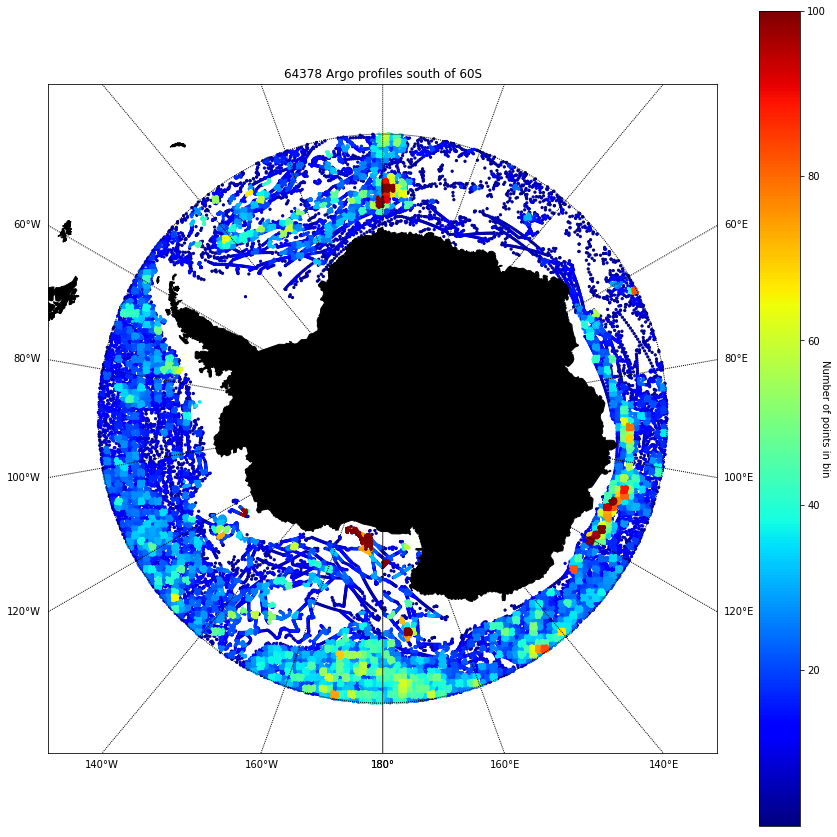

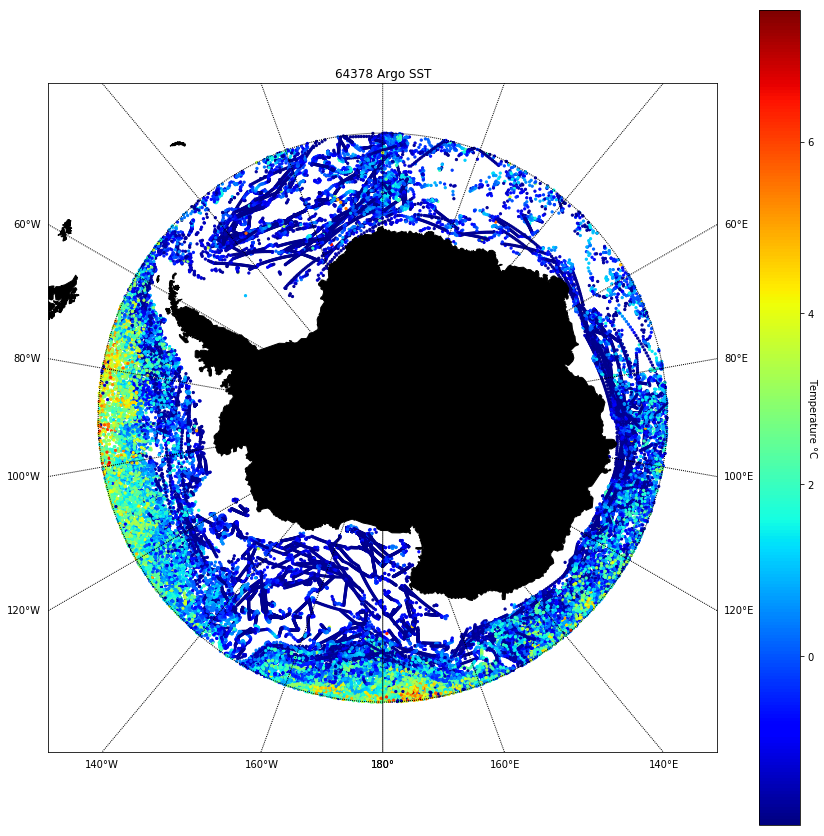

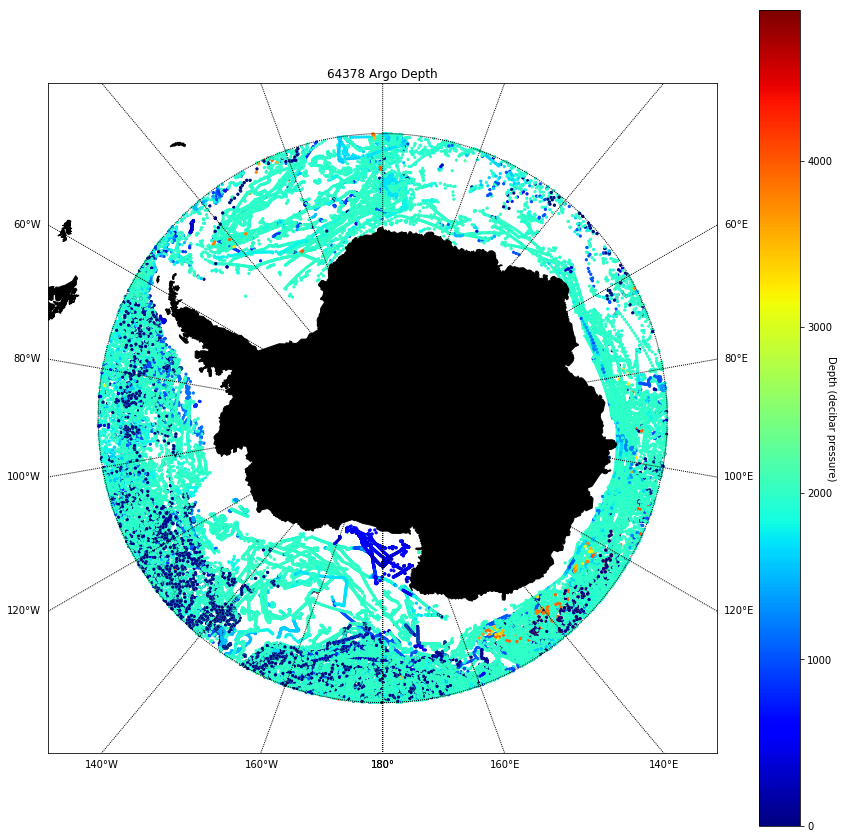

In [3]:
argo_lats, argo_lons, argo_dts, argo_sst, argo_depth = load_netcdf()
plot(argo_lats, argo_lons, vmax=100)
plot(argo_lats, argo_lons, argo_sst[:len(argo_lats)], title = "Argo SST", cbtitle = "Temperature °C")
plot(argo_lats, argo_lons, argo_depth[:len(argo_lats)], title = "Argo Depth", cbtitle = "Depth (decibar pressure)")

2001-12-21 15:53:45 2019-07-04 19:53:14


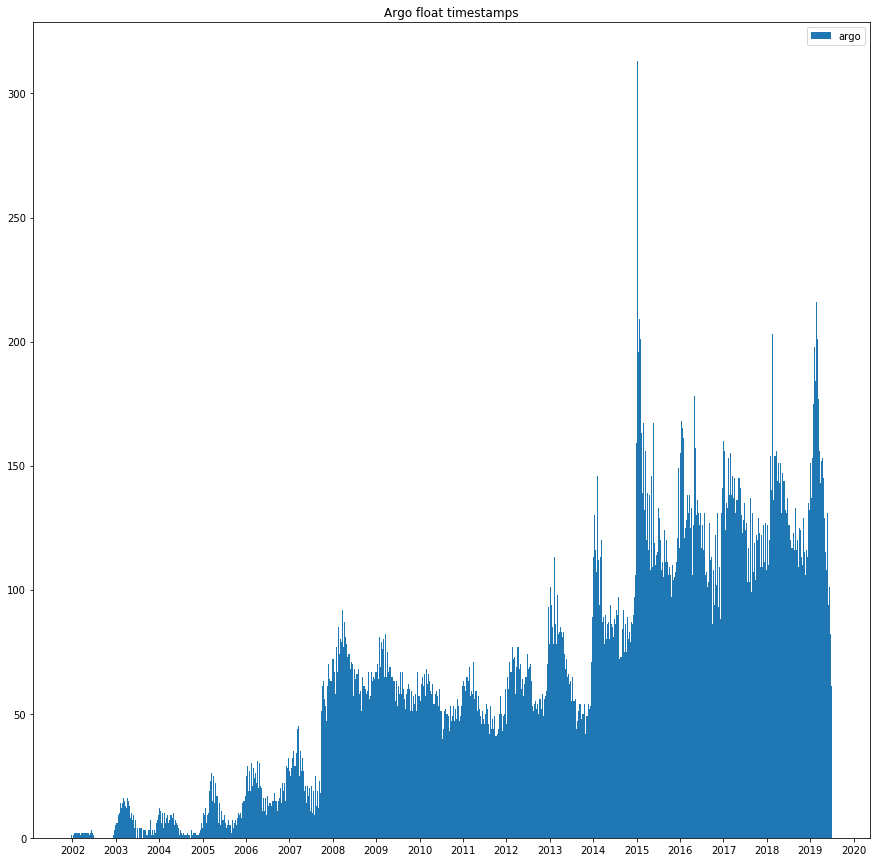

In [4]:
print(min(argo_dts), max(argo_dts))
plot_time(argo_dts, "Argo float timestamps", "argo")

748


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Warning: converting a masked element to nan.


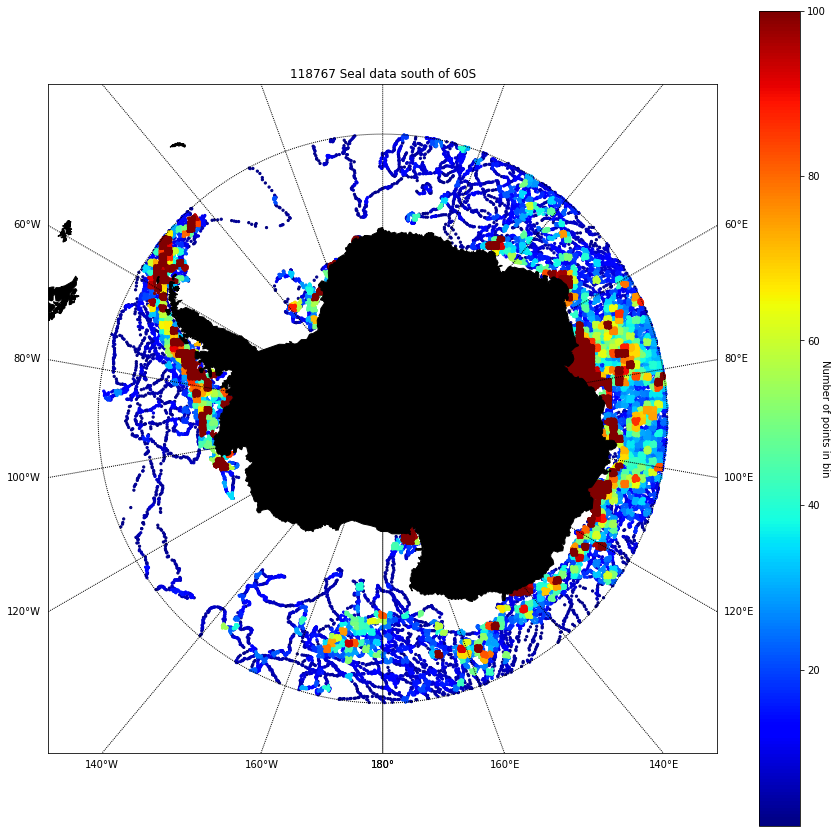

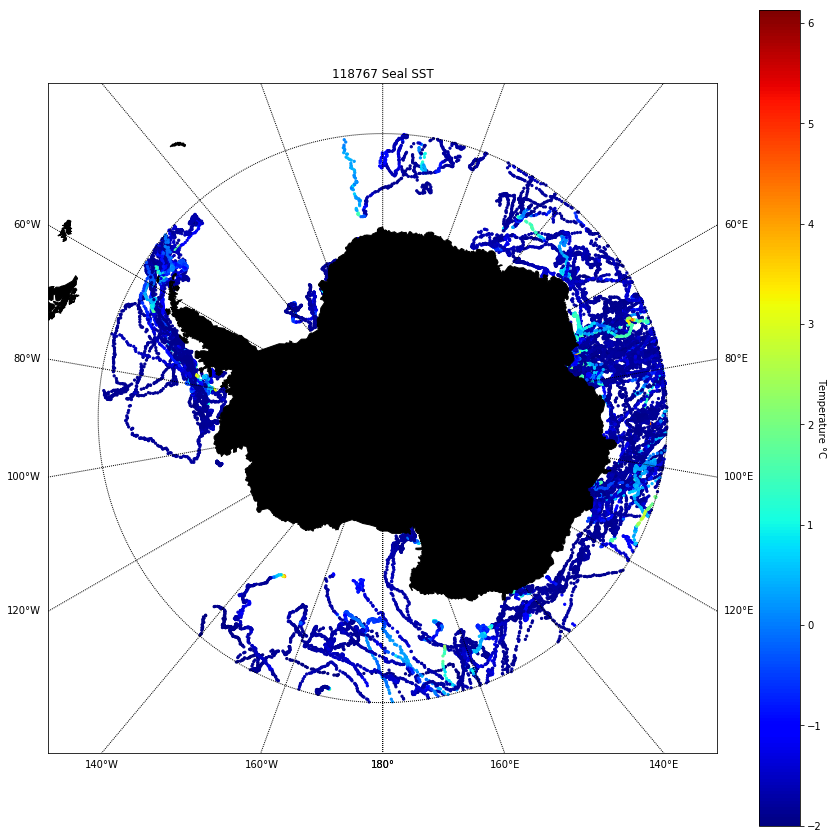

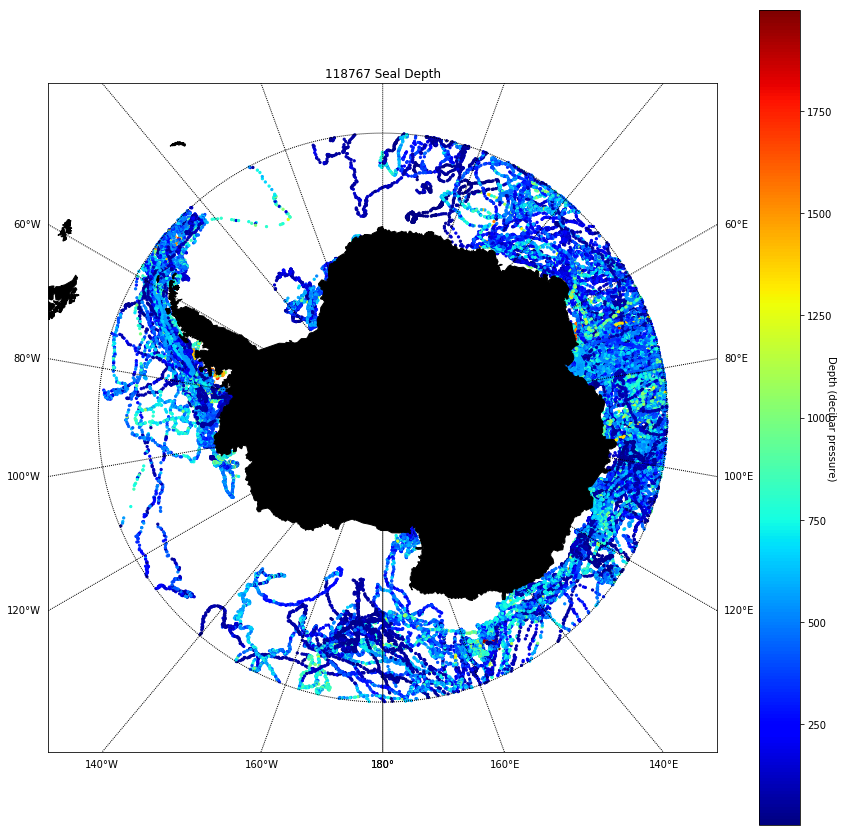

In [5]:
seal_lats, seal_lons, seal_dts, seal_sst, seal_depth = load_netcdf("seal")
plot(seal_lats, seal_lons, title = "Seal data south of 60S", vmax=100)
plot(seal_lats, seal_lons, seal_sst[:len(seal_lats)], title = "Seal SST", cbtitle = "Temperature °C")
plot(seal_lats, seal_lons, seal_depth[:len(seal_lats)], title = "Seal Depth", cbtitle = "Depth (decibar pressure)")

2004-01-27 11:48:59.999999 2018-01-14 23:00:00.000003


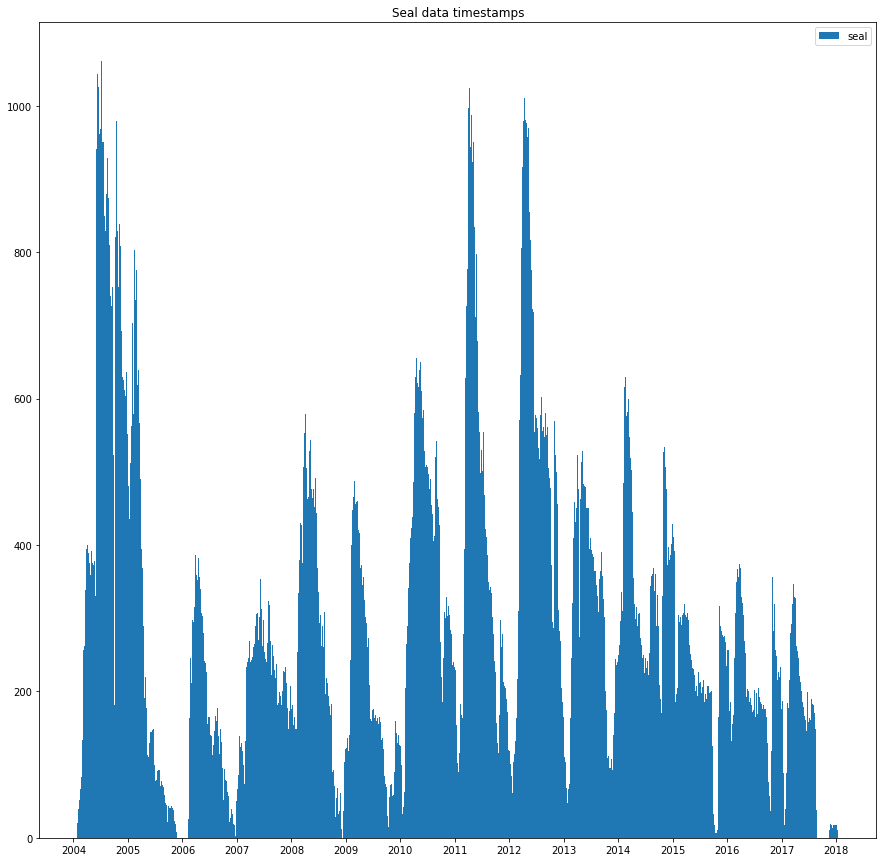

In [6]:
print(min(seal_dts), max(seal_dts))
plot_time(seal_dts, "Seal data timestamps", "seal")

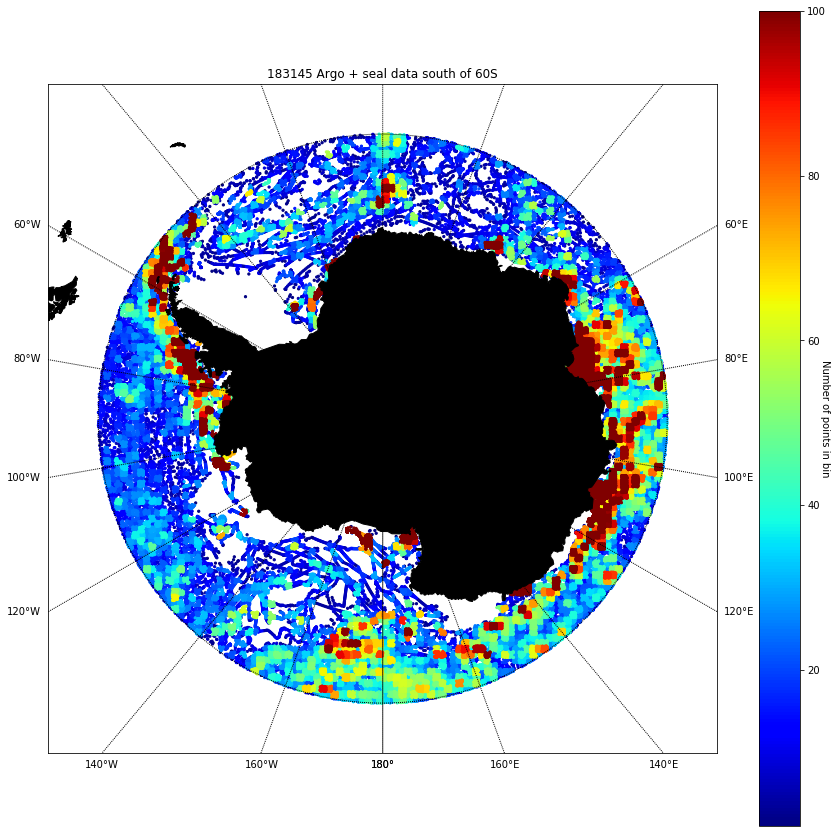

In [7]:
all_lats = np.concatenate((seal_lats, argo_lats))
all_lons = np.concatenate((seal_lons, argo_lons))
plot(all_lats, all_lons, title="Argo + seal data south of 60S", vmax=100)

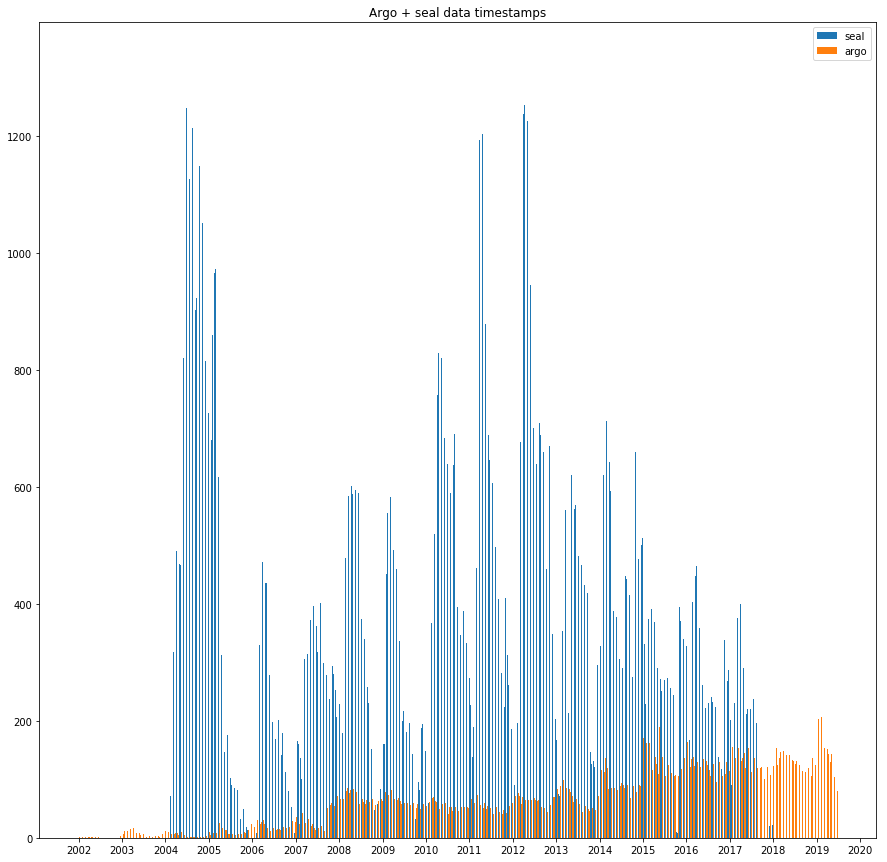

In [8]:
plot_time((seal_dts, argo_dts), "Argo + seal data timestamps", ["seal", "argo"])

In [35]:
def load_netcdf_grid(path = "Argo_South_60", resolution = 1):
    grid = np.full(shape=[15 * resolution, 360 * resolution], fill_value=np.nan)
    files = glob.glob("data/{}/**/*.nc".format(path), recursive=True)
    print(len(files))

    for f in tqdm(files[:]):
        d = Dataset(f)
        lat = d.variables["LATITUDE"][:]
        mask = (lat < -60) & (lat > -74.5)
        if any(mask):
            lat = np.round((np.abs(lat[mask]) - 60) * resolution).astype(int)
            lon = d.variables["LONGITUDE"][mask]
            lon = np.round((lon + 180) * resolution).astype(int)
            lon[lon == 360 * resolution] = 0
            #pres = np.round(d.variables["PRES_ADJUSTED"][mask] / 10).astype(int)
            temp = d.variables["TEMP_ADJUSTED"][mask, 0]
            for x in np.unique(lon):
                for y in np.unique(lat):
                    ptmask = (lon == x) & (lat == y) & (np.logical_not(np.isnan(temp)))
                    mean_for_pt = np.ma.mean(temp[ptmask])
                    if not np.isnan(mean_for_pt) and not np.ma.is_masked(mean_for_pt):
                        grid[y, x] = np.nanmean((grid[y, x], mean_for_pt))
    return grid

def plot_grid(grid, resolution = 1, title="Gridded SST mean for argo data", cbtitle="Temperature °C"):
    fig = plt.figure(figsize=(15,15))
    m = Basemap(projection='spstere',boundinglat=-55,lon_0=180,resolution='l')
    m.drawcoastlines()
    m.fillcontinents(color='black',lake_color='aqua')
    # draw parallels and meridians.
    m.drawparallels(np.arange(-60, 0, 20))
    m.drawmeridians(np.arange(-180, 181, 20), labels=[1,1,0,1])
    #m.drawmapboundary(fill_color='aqua')
    plt.title(title)

    x = np.arange(-180, 180, 1/resolution)
    y = np.arange(-60, -75, 1/-resolution)
    x, y = np.meshgrid(x, y)
    x, y = m(x, y)

    m.pcolormesh(x, y, grid, cmap="jet")
    cb = plt.colorbar()
    cb.set_label(cbtitle, rotation=270)
    plt.show()

In [38]:
resolution = 4
argo_grid = load_netcdf_grid(resolution = resolution)
seal_grid = load_netcdf_grid("seal", resolution = resolution)

1350



748


In [39]:
combined_grid = np.nanmean((argo_grid, seal_grid), axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


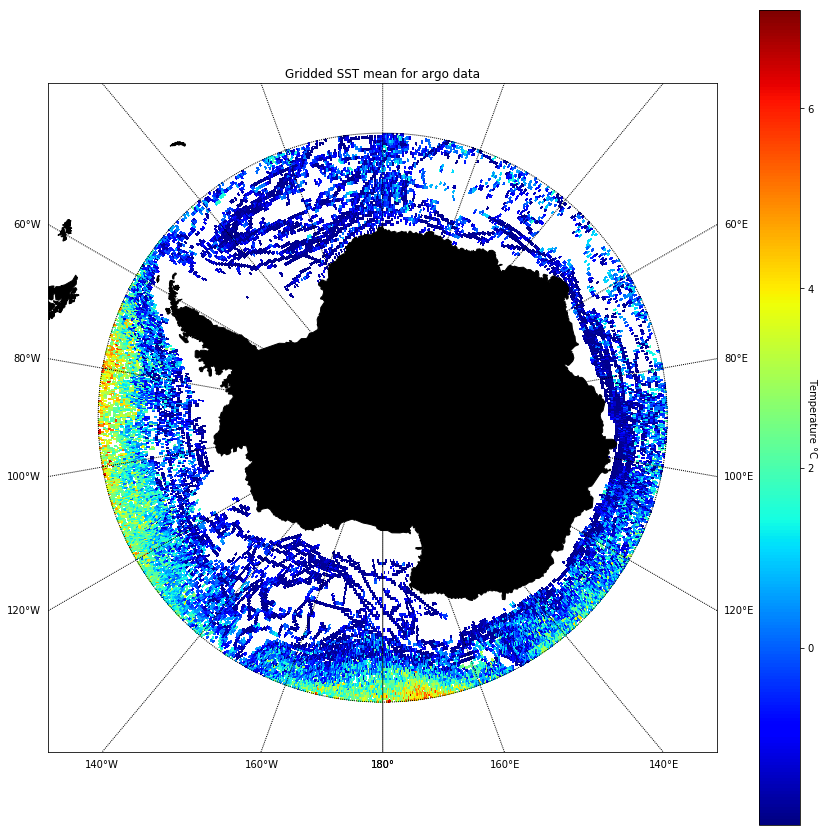

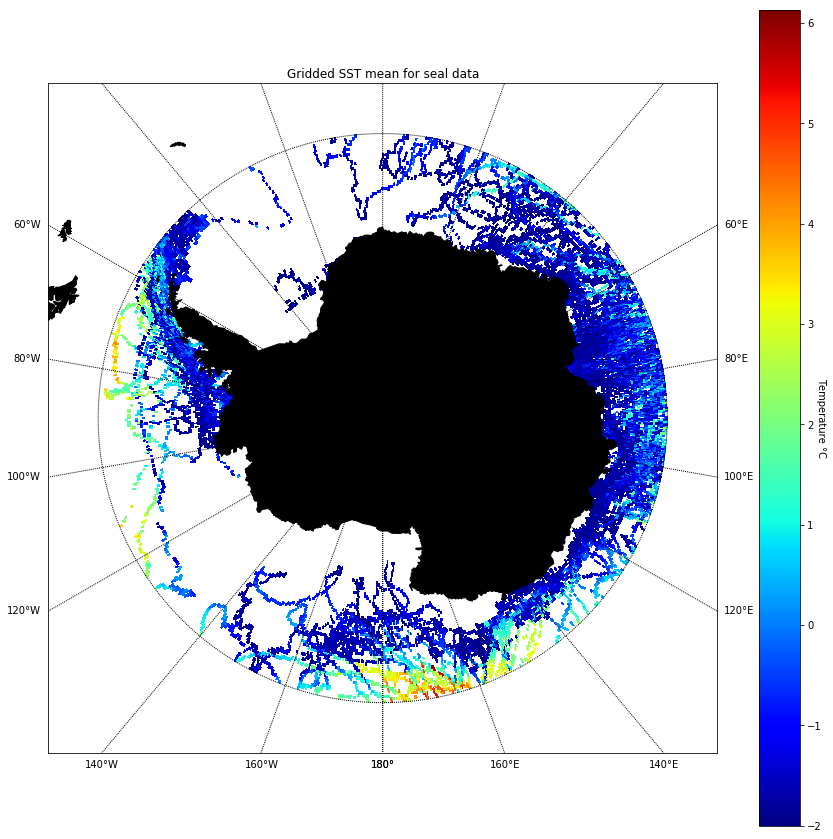

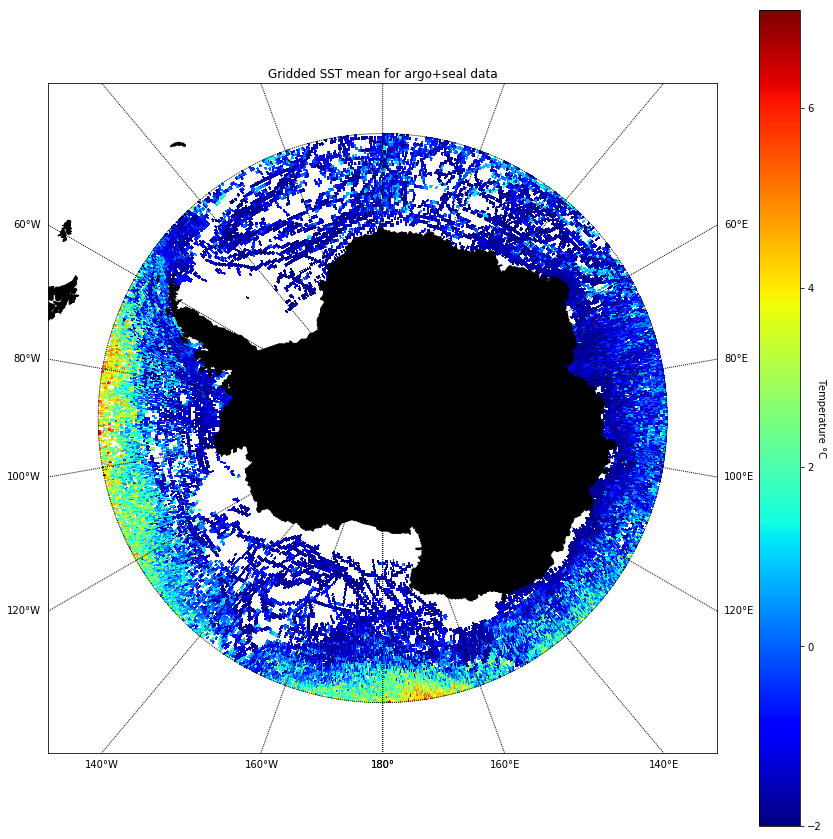

In [40]:
plot_grid(argo_grid, resolution = resolution)
plot_grid(seal_grid, title = "Gridded SST mean for seal data", resolution = resolution)
plot_grid(combined_grid, title = "Gridded SST mean for argo+seal data", resolution = resolution)

In [50]:
def interp_nans(grid):
    x = np.arange(0, grid.shape[1])
    y = np.arange(0, grid.shape[0])
    mask = np.isnan(grid)
    xx, yy = np.meshgrid(x, y)
    x1 = xx[~mask]
    y1 = yy[~mask]
    newarr = grid[~mask]
    interp = interpolate.griddata((x1, y1), newarr.ravel(), (xx, yy), method='linear')
    return interp

interp = interp_nans(combined_grid)

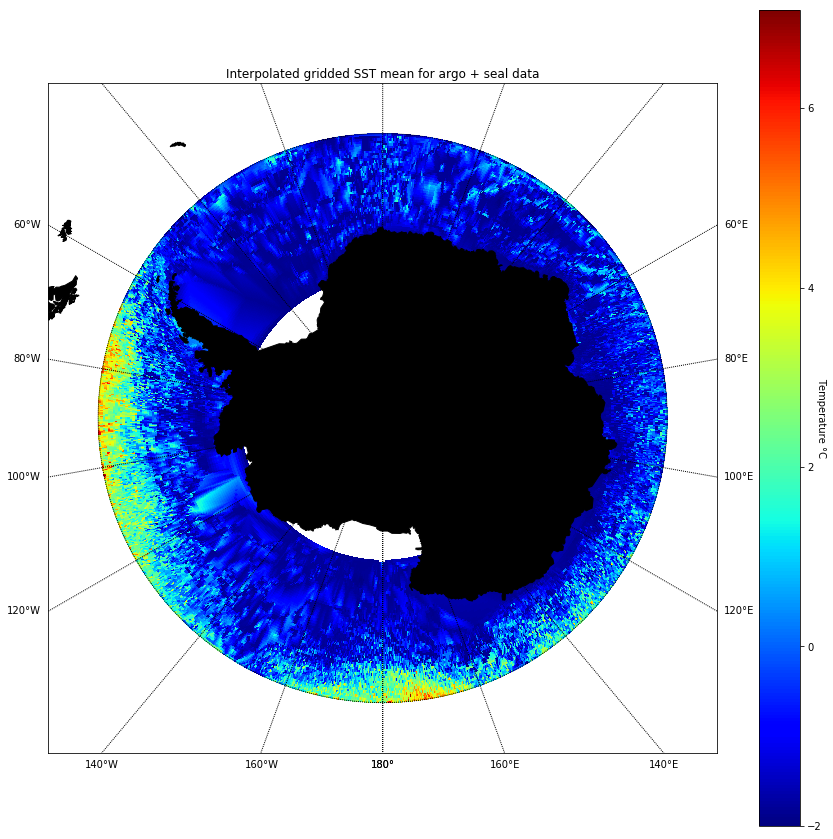

In [51]:
plot_grid(interp, resolution = resolution, title="Interpolated gridded SST mean for argo + seal data")